- Version: 1.0
- Last update: 2023-12-11
- Short description: This notebook is used to: clean, explore and transform the donor information data. Some first (quick) pre-checks have been applied as well.

## Install and Import

In [1]:
# Import modules
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import date


## Configuration

In [2]:
# Constants
ROOT_PATH = "../"
PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_LOG = "logs/"
PATH_MOD = "models/"
PATH_REP = "reports/"
PATH_FIG = "reports/figures/"
PATH_HTML = "reports/html/"

# parameters for notebook exports
notebook_name = "01.01_clean_donorinfo"  # only file name without extension

In [3]:
# Plotting
plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("seaborn-v0_8")
sns.set(rc={"figure.figsize": (12, 8)}, font_scale=0.8)

# Pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda val: "%.3f" % val)  # avoid scientific notation

# Warnings
warnings.filterwarnings("ignore")

## Load Data

In [4]:
# Load data
def load_data(path):
    return pd.read_parquet(ROOT_PATH + path)


file = "DonorInformation.csv"
df = pd.read_csv(ROOT_PATH + PATH_DATA_RAW + file)

## Main Part

### Checking df basics

In [5]:
df.head()

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1
1,326765656,H14.09.069,95-99,M,N,17,12,1-2 min,2,1,No Dementia,26,No Dementia,Y,White,Not Hispanic,No Dementia,5,2
2,326765654,H14.09.067,85,M,Y,10,72,< 10 sec,3,1,Vascular,25,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,2
3,467056391,H15.09.103,90-94,F,N,11,87,< 10 sec,0,1,No Dementia,52,No Dementia,Y,White,Not Hispanic,No Dementia,4,0
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2


#### Donor Information: Info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   donor_id                   107 non-null    int64 
 1   name                       107 non-null    object
 2   age                        107 non-null    object
 3   sex                        107 non-null    object
 4   apo_e4_allele              100 non-null    object
 5   education_years            107 non-null    int64 
 6   age_at_first_tbi           107 non-null    int64 
 7   longest_loc_duration       107 non-null    object
 8   cerad                      107 non-null    int64 
 9   num_tbi_w_loc              107 non-null    int64 
 10  dsm_iv_clinical_diagnosis  107 non-null    object
 11  control_set                107 non-null    int64 
 12  nincds_arda_diagnosis      107 non-null    object
 13  ever_tbi_w_loc             107 non-null    object
 14  race      

#### Donor Information: Describe - Numerical

In [7]:
df.describe()

,donor_id,education_years,age_at_first_tbi,cerad,num_tbi_w_loc,control_set,braak,nia_reagan
count,107.000,107.000,107.000,107.000,107.000,107.000,107.000,107.000
mean,326495420.607,14.150,20.822,1.477,0.607,28.178,3.421,1.598
std,38286865.104,3.227,30.350,1.085,0.711,15.699,1.727,0.856
min,309335438.000,6.000,0.000,0.000,0.000,1.000,0.000,0.000
25%,309335464.500,12.000,0.000,1.000,0.000,15.000,2.000,1.000
50%,309335493.000,14.000,0.000,1.000,0.000,28.000,3.000,1.000
75%,326765669.500,16.000,23.500,2.000,1.000,41.500,5.000,2.000
max,467056409.000,21.000,89.000,3.000,3.000,55.000,6.000,3.000


#### Donor Information: Describe - Object

In [8]:
df.describe(include="object")

,name,age,sex,apo_e4_allele,longest_loc_duration,dsm_iv_clinical_diagnosis,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented
count,107,107,107,100,107,107,107,107,107,107,107
unique,107,15,2,2,8,6,4,2,2,1,2
top,H14.09.078,90-94,M,N,Unknown or N/A,No Dementia,No Dementia,N,White,Not Hispanic,No Dementia
freq,1,28,63,80,61,56,56,54,105,107,57


### Correcting records based on Allen Institute documentation

Update TBI information for four donors who were initially thought not to have had a TBI.
Here is the specific changes that are made from the original file on the website based on new information:
- tbiInfo[donorInfo name=="H14.09.072",1] = "Y"
- tbiInfo[donorInfo name=="H14.09.072",2] = 50
- tbiInfo[donorInfo name=="H14.09.072",3] = 1
- tbiInfo[donorInfo name=="H14.09.072",4] = "10 sec - 1 min"
- tbiInfo[donorInfo name=="H14.09.018",1] = "Y"
- tbiInfo[donorInfo name=="H14.09.018",2] = 75
- tbiInfo[donorInfo name=="H14.09.018",3] = 1
- tbiInfo[donorInfo name=="H14.09.018",4] = "3-5 min"
- tbiInfo[donorInfo name=="H14.09.038",1] = "Y"
- tbiInfo[donorInfo name=="H14.09.038",2] = 64
- tbiInfo[donorInfo name=="H14.09.038",3] = 1
- tbiInfo[donorInfo name=="H14.09.038",4] = "10 sec - 1 min"
- tbiInfo[donorInfo name=="H14.09.034",1] = "Y"
- tbiInfo[donorInfo name=="H14.09.034",2] = 85
- tbiInfo[donorInfo name=="H14.09.034",3] = 1
- tbiInfo[donorInfo name=="H14.09.034",4] = "3-5 min"

Source: [Link](https://github.com/AllenInstitute/agedbrain/blob/master/Code01_ReadInDataAndFormat.r)

In [9]:
df.loc[df['name'] == "H14.09.072", "ever_tbi_w_loc"] = "Y"
df.loc[df['name'] == "H14.09.072", "age_at_first_tbi"] = 50
df.loc[df['name'] == "H14.09.072", "num_tbi_w_loc"] = 1
df.loc[df['name'] == "H14.09.072", "longest_loc_duration"] = "10 sec - 1 min"
#df[df['name'] == "H14.09.072"]

df.loc[df['name'] == "H14.09.018", "ever_tbi_w_loc"] = "Y"
df.loc[df['name'] == "H14.09.018", "age_at_first_tbi"] = 75
df.loc[df['name'] == "H14.09.018", "num_tbi_w_loc"] = 1
df.loc[df['name'] == "H14.09.018", "longest_loc_duration"] = "3-5 min"

df.loc[df['name'] == "H14.09.038", "ever_tbi_w_loc"] = "Y"
df.loc[df['name'] == "H14.09.038", "age_at_first_tbi"] = 64
df.loc[df['name'] == "H14.09.038", "num_tbi_w_loc"] = 1
df.loc[df['name'] == "H14.09.038", "longest_loc_duration"] = "10 sec - 1 min"

df.loc[df['name'] == "H14.09.034", "ever_tbi_w_loc"] = "Y"
df.loc[df['name'] == "H14.09.034", "age_at_first_tbi"] = 85
df.loc[df['name'] == "H14.09.034", "num_tbi_w_loc"] = 1
df.loc[df['name'] == "H14.09.034", "longest_loc_duration"] = "3-5 min"


### Checking: Missing Values

In [10]:
# Checking for missing values
df.isna().sum()

donor_id                     0
name                         0
age                          0
sex                          0
apo_e4_allele                7
education_years              0
age_at_first_tbi             0
longest_loc_duration         0
cerad                        0
num_tbi_w_loc                0
dsm_iv_clinical_diagnosis    0
control_set                  0
nincds_arda_diagnosis        0
ever_tbi_w_loc               0
race                         0
hispanic                     0
act_demented                 0
braak                        0
nia_reagan                   0
dtype: int64

- Seven missing values for **apo_e4_allele**

Checking values of apo_e4_allele:

In [11]:
df["apo_e4_allele"].value_counts()

apo_e4_allele
N    80
Y    20
Name: count, dtype: int64

In [12]:
df[df["apo_e4_allele"].isna()]

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
6,326765676,H14.09.089,89,F,NaN,12,13,10 min - 1 hr,3,1,Vascular,43,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,6,3
15,309335452,H14.09.015,81,M,NaN,16,23,> 1 hr,1,2,No Dementia,36,No Dementia,Y,White,Not Hispanic,No Dementia,1,1
29,309335479,H14.09.042,95-99,F,NaN,11,0,Unknown or N/A,3,0,Alzheimer's Disease Type,8,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,5,3
34,309335497,H14.09.060,86,F,NaN,12,0,Unknown or N/A,2,0,No Dementia,20,No Dementia,N,Non-white,Not Hispanic,No Dementia,4,2
41,309335481,H14.09.044,87,F,NaN,14,0,Unknown or N/A,2,0,Alzheimer's Disease Type,9,Probable Alzheimer'S Disease,N,White,Not Hispanic,Dementia,6,2
54,326765674,H14.09.087,100+,F,NaN,19,89,< 10 sec,2,1,Alzheimer's Disease Type,42,Possible Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,5,2
88,309335493,H14.09.056,100+,F,NaN,17,0,Unknown or N/A,3,0,Alzheimer's Disease Type,18,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,5,3


Replace missing values in the apo_e4_allele column with "Unknown":

In [13]:
df["apo_e4_allele"].fillna("Unknown", inplace=True)
df["apo_e4_allele"].value_counts()

apo_e4_allele
N          80
Y          20
Unknown     7
Name: count, dtype: int64

### Checking: Duplicates

In [14]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_count = len(duplicate_rows)

print("Duplicate count:", duplicate_count)

Duplicate count: 0


### Check Data Type Consistency

- Checking value consistency for categorical columns.
- Checking unique values for each object type column to identify any inconsistencies.

In [15]:
# Check value consistency for categorical columns
# Checking unique values for each object type column to identify any inconsistencies

unique_values = {}

for column in df.columns:
    if df[column].dtype == "object" and column != "name":
        unique_values[column] = df[column].unique()

unique_values

{'age': array(['87', '95-99', '85', '90-94', '100+', '89', '78', '83', '82', '77',
        '81', '88', '84', '86', '79'], dtype=object),
 'sex': array(['M', 'F'], dtype=object),
 'apo_e4_allele': array(['N', 'Y', 'Unknown'], dtype=object),
 'longest_loc_duration': array(['Unknown or N/A', '1-2 min', '< 10 sec', '10 min - 1 hr',
        '10 sec - 1 min', '> 1 hr', '3-5 min', '6-9 min'], dtype=object),
 'dsm_iv_clinical_diagnosis': array(['No Dementia', 'Vascular', "Alzheimer's Disease Type",
        'Multiple Etiologies', 'Other or Unknown Cause', 'Other Medical'],
       dtype=object),
 'nincds_arda_diagnosis': array(['No Dementia', 'Dementia, Type Unknown',
        "Possible Alzheimer'S Disease", "Probable Alzheimer'S Disease"],
       dtype=object),
 'ever_tbi_w_loc': array(['N', 'Y'], dtype=object),
 'race': array(['White', 'Non-white'], dtype=object),
 'hispanic': array(['Not Hispanic'], dtype=object),
 'act_demented': array(['No Dementia', 'Dementia'], dtype=object)}

- The age column has some ranges like '95-99' and '90-94', and also values like '100+'.
- The longest_loc_duration column has various time intervals, including 'Unknown or N/A'.
- Other columns seem to have fairly consistent values, but it depends on the domain knowledge
and expected values for the dataset.

We are also looking for columns with mix data types:
- For each value in a column, we check if the value is a numeric string (using the is_number helper function) or if it's one of the allowed outlier values (like "NA").
- If a value is found that is neither a numeric string nor an allowed outlier, the column is flagged as inconsistent.

In [16]:
def is_number(s):
    try:
        float(s)  # for int, long and float
    except ValueError:
        return False

    return True


def highlight_inconsistent_types(df_temp, outlier_values=None):
    # Create a dictionary to store the consistency status of each column
    if outlier_values is None:
        outlier_values = ["NA"]
    type_consistency = {col: True for col in df_temp.columns}

    # Iterate over each column and check data types
    for col in df_temp.columns:
        # Check if all values in the column are either numeric or one of the specified outliers
        for record in df_temp[col]:
            if record not in outlier_values and not is_number(record):
                type_consistency[col] = False
                break  # No need to check further values in this column

    # Highlight the inconsistent columns
    inconsistent_columns_list = [
        col for col, consistent in type_consistency.items() if not consistent
    ]
    return inconsistent_columns_list


inconsistent_columns = highlight_inconsistent_types(df)
print("Columns with inconsistent or mixed data types:")
inconsistent_columns

Columns with inconsistent or mixed data types:


['name',
 'age',
 'sex',
 'apo_e4_allele',
 'longest_loc_duration',
 'dsm_iv_clinical_diagnosis',
 'nincds_arda_diagnosis',
 'ever_tbi_w_loc',
 'race',
 'hispanic',
 'act_demented']

### Check Distributions & Apply Binning


#### Age (of death) Value Counts

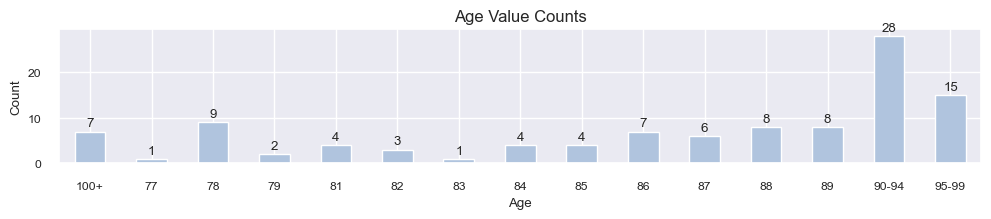

In [17]:
# Get value counts
age_value_counts = df["age"].value_counts().sort_index()

# Create the bar chart
ax = age_value_counts.plot(
    kind="bar", figsize=(10, 2.5), title="Age value counts", color="lightsteelblue"
)

# Add value counts on top of each bar
for idx, value in enumerate(age_value_counts):
    ax.text(
        idx, value + 0.5, str(value), ha="center", va="bottom"
    )  # you can adjust 0.5 to place the text appropriately

plt.style.use("seaborn-v0_8")
plt.title("Age Value Counts")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.tick_params(axis="x", rotation=0)
plt.show()

- Most donors fall within the age range of 90-94.
- Age ranges like '90-94' and '95-99' suggest that exact ages within these intervals were not
recorded.
- The '100+' category indicates donors who are 100 years old or older, but the exact age is not
specified.

In [18]:
# df.shape
# df.head()

#### Age Binning

- We strive to categorize the age information in order to obtain a dataset that is evenly distributed, while also ensuring the preservation of the current groups: 90-94, 95-99, 100+.

In [19]:
# Creating new bins for the age column
def bin_ages(age):
    if age == "100+":
        return "100+"
    elif age == "90-94":
        return "90-94"
    elif age == "95-99":
        return "95-99"
    elif 87 <= int(age) <= 89:
        return "87-89"
    elif 81 <= int(age) <= 86:
        return "81-86"
    elif 77 <= int(age) <= 79:
        return "77-79"
    else:
        return age  # This will retain any ages not covered by the bins above


# Apply the binning function to the age column
df["age_bin"] = df["age"].apply(bin_ages)

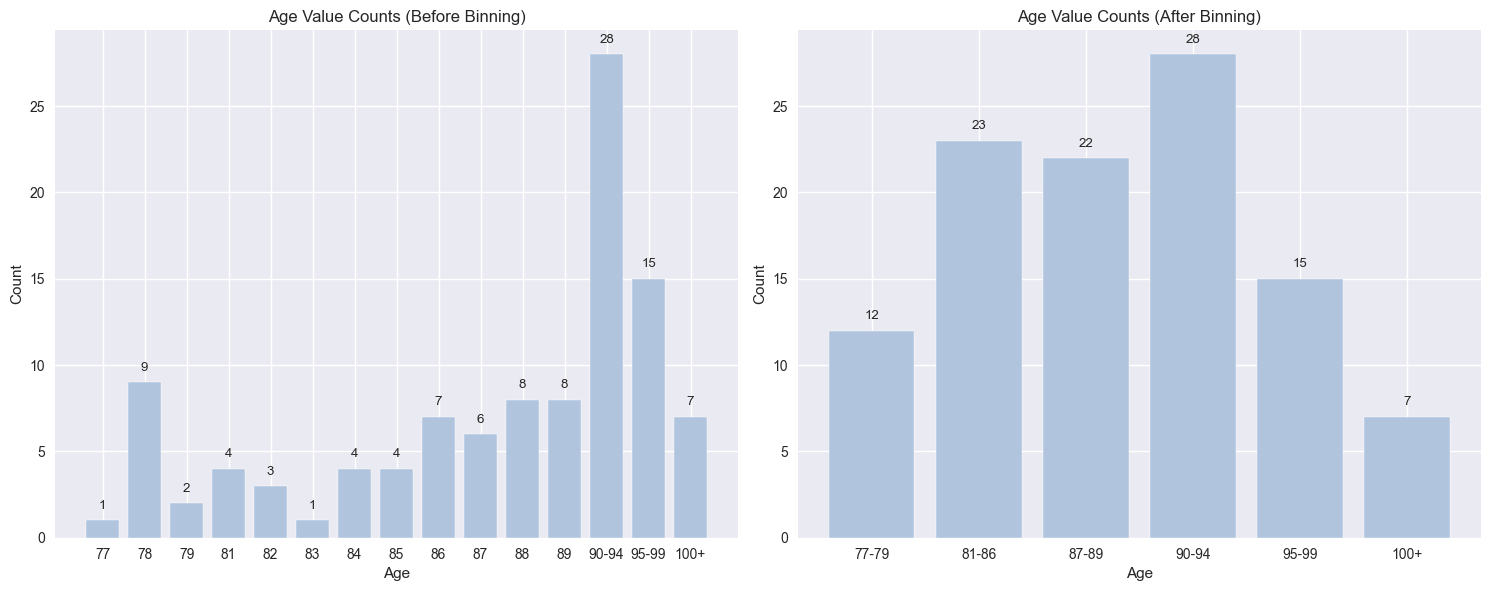

In [20]:
# Adjust the order to move the "100+" bin to the rightmost end
# Original age distribution
age_distribution = df["age"].value_counts().sort_index()

# New (re-binned) age distribution
new_age_distribution = df["age_bin"].value_counts().sort_index()

ordered_age_before = age_distribution.reindex(
    sorted(age_distribution.index, key=lambda val: (val == "100+", val))
)
ordered_age_after = new_age_distribution.reindex(
    sorted(new_age_distribution.index, key=lambda val: (val == "100+", val))
)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distribution before re-binning with ordered ages
bars1 = ax1.bar(
    ordered_age_before.index, ordered_age_before.values, color="lightsteelblue"
)
ax1.set_title("Age Value Counts (Before Binning)")
ax1.set_xlabel("Age")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=0)

# Add value counts for ax1
for bar in bars1:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        round(yval, 1),
        ha="center",
        va="bottom",
    )

# Plot the distribution after re-binning with ordered ages
bars2 = ax2.bar(
    ordered_age_after.index, ordered_age_after.values, color="lightsteelblue"
)
ax2.set_title("Age Value Counts (After Binning)")
ax2.set_xlabel("Age")
ax2.set_ylabel("Count")
ax2.tick_params(axis="x", rotation=0)

# Add value counts for ax2
for bar in bars2:
    yval = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        round(yval, 1),
        ha="center",
        va="bottom",
    )

# Adjust the layout
plt.tight_layout()
plt.show()

In [21]:
df.shape

(107, 20)

#### Age Cleaning


- We are also generating a new attribute called "age_clean" to retain the quantitative data of the age.
- We will use the median.

In [22]:
# Creating new values for the age column
def clean_ages(age):
    if age == "100+":
        return float(101)
    elif age == "90-94":
        return np.median([90, 94])
    elif age == "95-99":
        return np.median([95, 99])
    else:
        return float(age)


# Apply the binning function to the age column
df["age_clean"] = df["age"].apply(clean_ages)

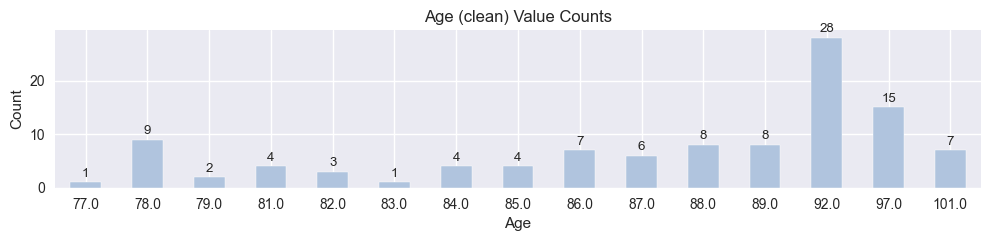

In [23]:
# Get value counts for each unique age value
age_value_counts = df["age_clean"].value_counts().sort_index()

# Create the bar chart
ax = age_value_counts.plot(
    kind="bar", figsize=(10, 2.5), title="Age (clean) value counts", color="lightsteelblue"
)

# Add value counts on top of each bar
for idx, value in enumerate(age_value_counts):
    ax.text(
        idx, value + 0.5, str(value), ha="center", va="bottom"
    )  # you can adjust 0.5 to place the text appropriately

plt.tick_params(axis="x", rotation=0)
plt.title("Age (clean) Value Counts")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [24]:
df.shape

(107, 21)

#### age_at_first_tbi value counts

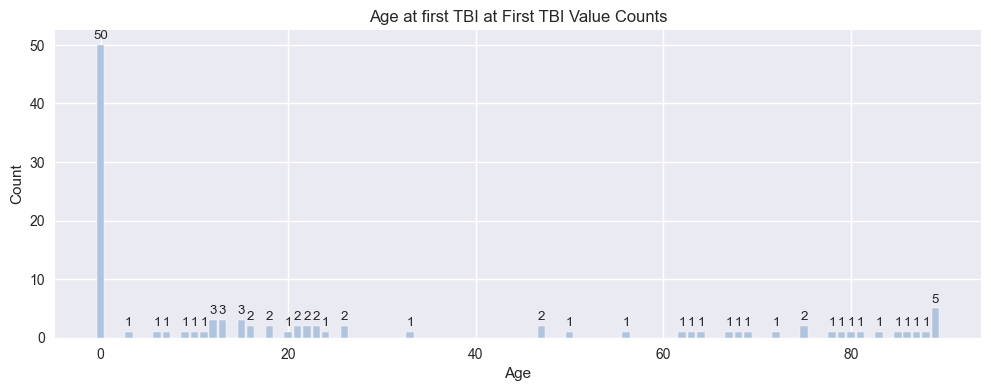

In [25]:
# Get value counts for each unique age value
age_tbi_value_counts = df["age_at_first_tbi"].value_counts().sort_index()

# Plotting the real values distribution
plt.figure(figsize=(10, 4))
bars = plt.bar(
    age_tbi_value_counts.index, age_tbi_value_counts.values, color="lightsteelblue"
)

# Add value counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        str(yval),
        ha="center",
        va="bottom",
    )

plt.title("Age at first TBI at First TBI Value Counts")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- A large number of donors (54) have an age value of 0 for their first TBI. This could potentially be
  a placeholder for missing data or indicating that they never experienced a TBI -> Based on the study documentation, we have discovered that excluding 0 is necessary to ensure an accurate distribution, as 0 indicates the absence of TBI. This observation aligns with the ever_tbi_w_loc column.
- The data spans a wide range of ages, from early childhood to advanced age.

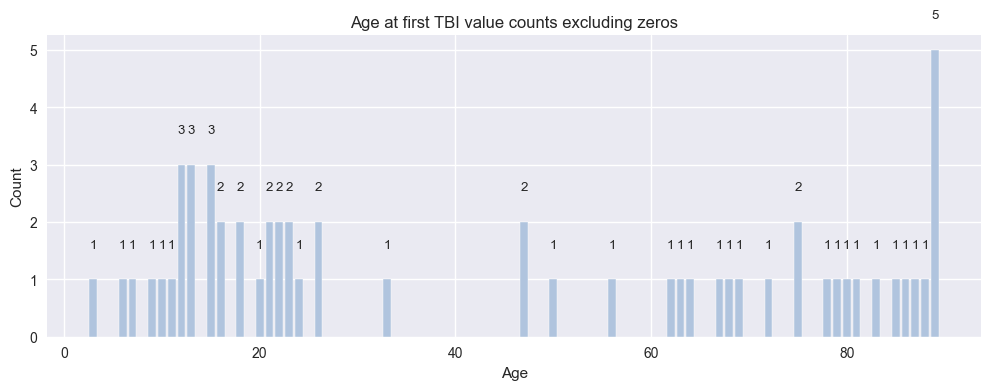

In [26]:
# Filter out rows with 0 value for 'age_at_first_tbi'
non_zero_age_tbi = df[df["age_at_first_tbi"] != 0]["age_at_first_tbi"]

# Get the value counts for each unique age value and sort by index
age_tbi_value_counts = non_zero_age_tbi.value_counts().sort_index()

# Plot the real values distribution using bars
plt.figure(figsize=(10, 4))
bars = plt.bar(
    age_tbi_value_counts.index, age_tbi_value_counts.values, color="lightsteelblue"
)

# Add value counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        str(yval),
        ha="center",
        va="bottom",
    )

plt.title("Age at first TBI value counts excluding zeros")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- A significant number of TBI incidents occur during early stages of life, as the majority of donors encounter their initial TBI before reaching the age of 30. Another notable concentration can be observed from the age of 60 onwards.
- To reflect this observation, we will establish three categories: early, mid, late:
  - 1 <= age <= 30: "early_years (1-30)"
  - 31 <= age <= 60: "mid_years (31-60)"
  - 61 <= age <= 90:l "late_years (61-90)"
  - Otherwise "NA"

In [27]:
def label_age_group(age):
    if 1 <= age <= 30:
        return "early_years (1-30)"
    elif 31 <= age <= 60:
        return "mid_years (31-60)"
    elif 61 <= age <= 90:
        return "late_years (61-90)"
    return "NA"


df["age_at_first_tbi_bin"] = df["age_at_first_tbi"].apply(label_age_group)

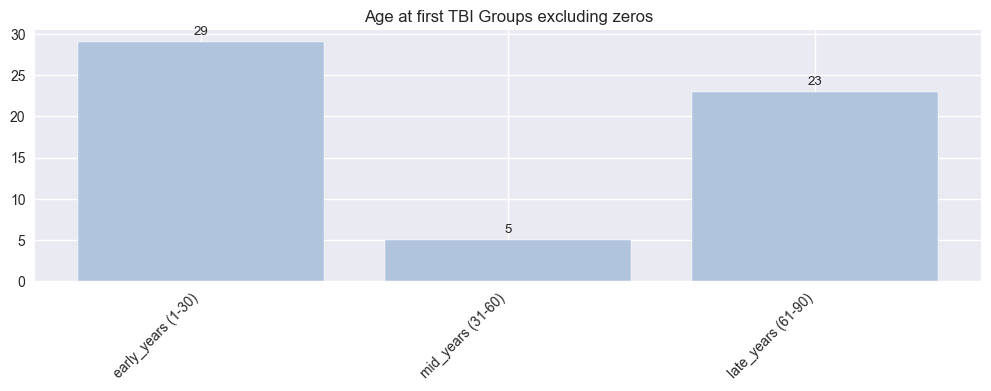

In [28]:
# Desired order
order = ["early_years (1-30)", "mid_years (31-60)", "late_years (61-90)"]

# Filter out rows with 0 value for 'age_at_first_tbi_group'
non_zero_age_tbi = df[df["age_at_first_tbi_bin"] != 0]["age_at_first_tbi_bin"]

# Get the value counts for each unique age value
age_tbi_value_counts = non_zero_age_tbi.value_counts()

# Reorder the data based on the desired order
age_tbi_value_counts = age_tbi_value_counts.reindex(order)

# Plot the values distribution using bars
plt.figure(figsize=(10, 4))
bars = plt.bar(
    age_tbi_value_counts.index, age_tbi_value_counts.values, color="lightsteelblue"
)

# Add value counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        str(yval),
        ha="center",
        va="bottom",
    )

plt.title("Age at first TBI Groups excluding zeros")
plt.xticks(rotation=45, ha="right")  # Rotate x-ticks for better visibility
plt.tight_layout()
plt.show()

In [29]:
df.shape

(107, 22)

#### education_years - education stages

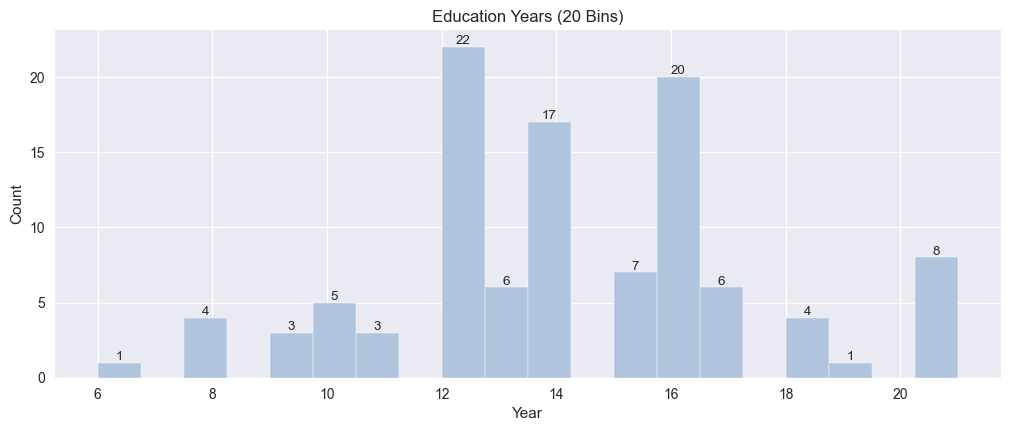

In [30]:
# Set the size of the figure first
plt.figure(figsize=(10, 4))

# Create the histogram and capture the returned values
counts, bins, patches = plt.hist(df["education_years"], bins=20, color="lightsteelblue")

# Annotate the bars with counts
for count, patch in zip(counts, patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    # Use an f-string for clearer code and check if count is non-zero to avoid cluttering the plot
    if count > 0:
        plt.annotate(f"{int(count)}", (x, y), ha="center", va="bottom")

# Use tight_layout to automatically adjust subplot params for a nice fit within the figure
plt.tight_layout()

# Display the plot
plt.title("Education Years (20 Bins)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

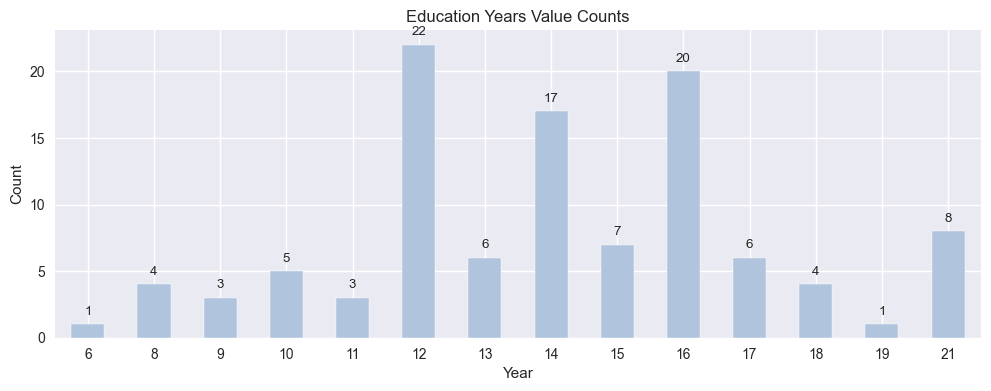

In [31]:
# Analyze the 'education_years' column
education_years_value_counts = df["education_years"].value_counts().sort_index()

plt.figure(figsize=(10, 4))

# Create the bar chart
ax = education_years_value_counts.plot(kind="bar", color="lightsteelblue")

# Add numbers on top of each bar
for idx, value in enumerate(education_years_value_counts):
    ax.text(
        idx, value + 0.5, str(value), ha="center", va="bottom"
    )  # you can adjust 0.5 to place the text appropriately

plt.title("Education Years Value Counts")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

- The most common education duration is 12 years, which typically corresponds to the completion of high school in many education systems.
- The mean years of education is slightly over 14 years, indicating that, on average, the donors have some education beyond high school.
- The wide range, from 6 to 21 years, shows a diverse group of donors in terms of educational background.

We are creating an education years grouping which follows the typical educational stages in the US:
- 'Less than High School (0-11 years)'
- 'High School Graduate (12 years)'
- 'Some College (no degree) (13-15 years)'
- 'Associate's or Bachelor's Degree (16-18 years)'
- 'Graduate or Professional Degree (19+ years)'

In [32]:
edu_bin_edges = [5, 12, 13, 16, 19, df["education_years"].max() + 1]
edu_bin_labels = ["5-11 years", "12 years", "13-15 years", "16-18 years", "19+ years"]

# Create bins for the education_years column based on the educational stages
df["education_years_stages_bin"] = pd.cut(
    df["education_years"], bins=edu_bin_edges, labels=edu_bin_labels, right=False
)

# Check the value counts for the new bins
education_stages_counts = df["education_years_stages_bin"].value_counts().sort_index()

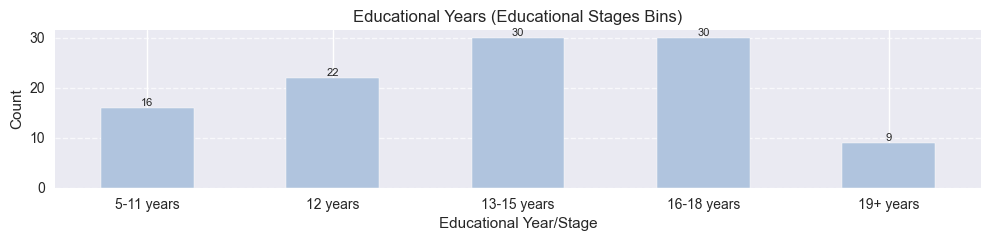

In [33]:
plt.figure(figsize=(10, 2.5))
bars = education_stages_counts.plot(kind="bar", color="lightsteelblue")

# Add the text annotations to each bar.
for bar in bars.patches:
    # The bar height can be accessed with bar.get_height()
    height = bar.get_height()
    # You can add a text annotation with plt.annotate()
    plt.annotate(
        f"{int(height)}",
        (bar.get_x() + bar.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=8,
    )  # Adjust fontsize as needed

# Add labels and grid
plt.title("Educational Years (Educational Stages Bins)")
plt.xlabel("Educational Year/Stage")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### education years - quartiles binning

We're also generating quartile-based bins (creating 4 equally sized bins) for a better distribution of the feature:

In [34]:
df["education_years_quartiles_bin"] = pd.qcut(
    df["education_years"], q=4, duplicates="drop"
)

intervals = pd.qcut(df["education_years"], q=4, duplicates="drop").cat.categories
new_labels = [
    f"{int(interval.left)}-{int(interval.right)} years" for interval in intervals
]
df["education_years_quartiles_bin"] = df[
    "education_years_quartiles_bin"
].cat.rename_categories(new_labels)

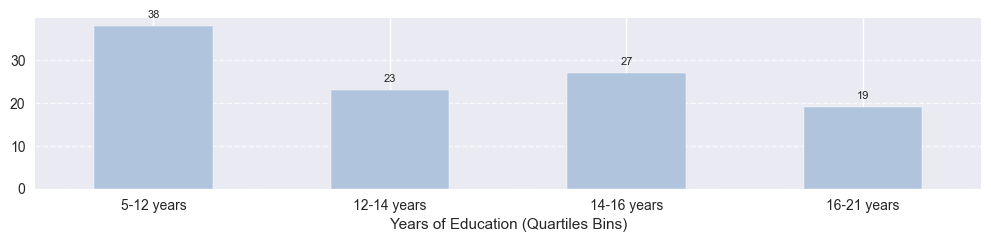

In [35]:
plt.figure(figsize=(10, 2.5))
bar_plot = (
    df["education_years_quartiles_bin"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", color="lightsteelblue")
)

# Iterate over each bar and use `annotate` to display the count above the bar
for bar in bar_plot.patches:
    bar_plot.annotate(
        format(bar.get_height(), ".0f"),  # Format the count to one decimal place
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="center",
        size=8,
        xytext=(0, 8),
        textcoords="offset points",
    )

plt.xlabel("Years of Education (Quartiles Bins)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### longest_loc_duration value counts

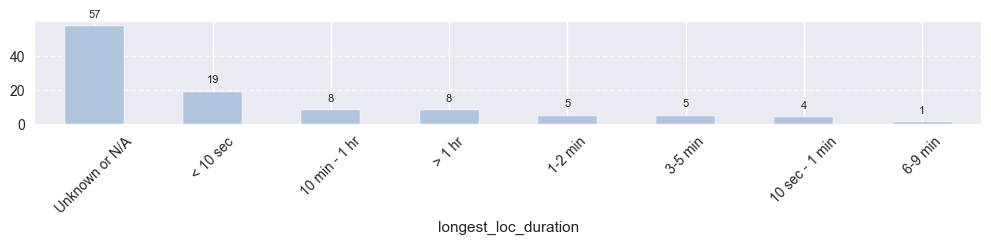

In [36]:
# Calculate the value counts and plot the bar chart
longest_loc_value_counts = df["longest_loc_duration"].value_counts()
bar_plot = longest_loc_value_counts.plot(
    kind="bar", color="lightsteelblue", figsize=(10, 2.5)
)

# Annotate the bars with the count
for bar in bar_plot.patches:
    bar_plot.annotate(
        format(bar.get_height(), "d"),  # Format the count as an integer
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        size=8,
        xytext=(0, 5),
        textcoords="offset points",
    )

# Optional: Add labels and a grid if you want
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- A significant number of donors (61) have "Unknown or N/A" as their longest LOC duration, which
  could be due to either not having experienced a LOC or missing data.
- Shorter LOC durations, especially less than 10 seconds, are relatively common with 19 entries.
- There are also donors who have experienced longer durations of LOC, ranging from 10 minutes to
  more than an hour.

In [37]:
TBI_with_no_loc_Duration = df[(df['longest_loc_duration'] == "Unknown or N/A") & (df['ever_tbi_w_loc'] == "Y")][["name", "donor_id","num_tbi_w_loc","ever_tbi_w_loc","longest_loc_duration", "cerad", "apo_e4_allele"]]

TBI_with_no_loc_Duration

,name,donor_id,num_tbi_w_loc,ever_tbi_w_loc,longest_loc_duration,cerad,apo_e4_allele
13,H14.09.093,326765680,1,Y,Unknown or N/A,3,N
25,H14.09.055,309335492,1,Y,Unknown or N/A,2,N
48,H14.09.099,326765686,3,Y,Unknown or N/A,1,N
68,H14.09.059,309335496,1,Y,Unknown or N/A,0,N
93,H14.09.081,326765668,1,Y,Unknown or N/A,2,Y
96,H14.09.097,326765684,1,Y,Unknown or N/A,1,N
106,H14.09.005,309335442,2,Y,Unknown or N/A,1,Y


In [38]:
TBI_with_no_loc_Duration.shape

(7, 7)

In [39]:
no_TBI_with_no_loc_Duration  = df[(df['longest_loc_duration'] == "Unknown or N/A") & (df['ever_tbi_w_loc'] == "N")][["name", "donor_id","num_tbi_w_loc","ever_tbi_w_loc","longest_loc_duration", "cerad"]]

no_TBI_with_no_loc_Duration

,name,donor_id,num_tbi_w_loc,ever_tbi_w_loc,longest_loc_duration,cerad
0,H14.09.078,326765665,0,N,Unknown or N/A,0
4,H14.09.010,309335447,0,N,Unknown or N/A,3
5,H14.09.020,309335457,0,N,Unknown or N/A,2
7,H14.09.094,326765681,0,N,Unknown or N/A,1
9,H14.09.070,326765657,0,N,Unknown or N/A,0
10,H14.09.006,309335443,0,N,Unknown or N/A,0
12,H14.09.074,326765661,0,N,Unknown or N/A,1
19,H14.09.008,309335445,0,N,Unknown or N/A,3
22,H14.09.032,309335469,0,N,Unknown or N/A,1
23,H15.09.110,467056409,0,N,Unknown or N/A,2


In [40]:
no_TBI_with_no_loc_Duration.shape

(50, 6)

- We have 7 records where a TBI event was recorded, however, the longest_loc_duration is "Unknown or N/A". For these records, we set the longest duration to -1
- We have 50 records with no TBI, for those we set the longest_loc_duration to 0

We're merging different groups to achieve a more balanced distribution:
- Combining "10 sec - 1 min" with "1-2 min" to create "10 sec - 2 min".
- Combining "6-9 min" with "10 min - 1 hr" to create "6 min - 1 hr".
- Further combining "10 sec - 2 min" with "3-5 min" to create "10 sec - 5 min".

In [41]:
# Define a function to bin durations based on the criteria
def bin_durations(duration):
    if duration in ["10 sec - 1 min", "1-2 min"]:
        return "10 sec - 2 min"
    elif duration in ["6-9 min", "10 min - 1 hr"]:
        return "6 min - 1 hr"
    else:
        return duration


# Apply the first binning function
df["longest_loc_duration_bin"] = df["longest_loc_duration"].apply(bin_durations)


# Define a function to further bin durations
def combine_durations(duration):
    if duration in ["10 sec - 2 min", "3-5 min"]:
        return "10 sec - 5 min"
    else:
        return duration


# Apply the second binning function
df["longest_loc_duration_bin"] = df["longest_loc_duration_bin"].apply(combine_durations)

loc_duration_counts = df["longest_loc_duration_bin"].value_counts().sort_index()

In [42]:
sequence_after = ["< 10 sec", "10 sec - 5 min", "6 min - 1 hr", "> 1 hr"]

# Reorder the distributions based on the sequences
ordered_after = loc_duration_counts.reindex(sequence_after).dropna()

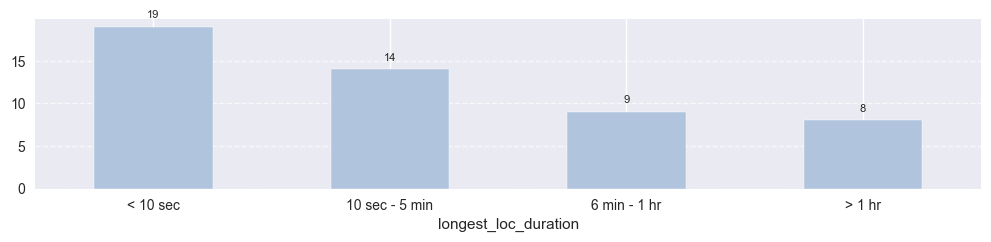

In [43]:
plt.figure(figsize=(10, 2.5))
bars = ordered_after.plot(kind="bar", color="lightsteelblue")

# Iterate over the bars and use 'annotate' to display the count above each bar
for bar in bars.patches:
    plt.annotate(
        f"{int(bar.get_height())}",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.xlabel("longest_loc_duration")
# plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### longest_loc_duration cleaning

- We are also generating a new attribute called "longest_loc_duration_clean" to retain the quantitative data of the longest_loc_duration.
- We convert all time ranges to seconds and use the median.

In [44]:
# Creating new values for the age column
def clean_longest_loc_durations(longest_loc_duration):
    if longest_loc_duration == "< 10 sec":
        return np.median([1, 10])
    elif longest_loc_duration == "10 sec - 1 min":
        return np.median([10, 60])
    elif longest_loc_duration == "1-2 min":
        return np.median([60, 120])
    elif longest_loc_duration == "3-5 min":
        return np.median([180, 300])
    elif longest_loc_duration == "6-9 min":
        return np.median([360, 540])
    elif longest_loc_duration == "10 min - 1 hr":
        return np.median([600, 3600])
    elif longest_loc_duration == "> 1 hr":
        return float(3660)
    else:
        return longest_loc_duration

# Apply the binning function to the age column
df["longest_loc_duration_clean"] = df["longest_loc_duration"].apply(
    clean_longest_loc_durations
)


In [45]:
df[(df['longest_loc_duration'] == "Unknown or N/A") & (df['ever_tbi_w_loc'] == "Y")]

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan,age_bin,age_clean,age_at_first_tbi_bin,education_years_stages_bin,education_years_quartiles_bin,longest_loc_duration_bin,longest_loc_duration_clean
13,326765680,H14.09.093,77,M,N,12,12,Unknown or N/A,3,1,Other or Unknown Cause,46,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,6,3,77-79,77.000,early_years (1-30),12 years,5-12 years,Unknown or N/A,Unknown or N/A
25,309335492,H14.09.055,100+,F,N,12,89,Unknown or N/A,2,1,Alzheimer's Disease Type,18,Possible Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,6,2,100+,101.000,late_years (61-90),12 years,5-12 years,Unknown or N/A,Unknown or N/A
48,326765686,H14.09.099,90-94,M,N,21,88,Unknown or N/A,1,3,Alzheimer's Disease Type,50,Possible Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,3,1,90-94,92.000,late_years (61-90),19+ years,16-21 years,Unknown or N/A,Unknown or N/A
68,309335496,H14.09.059,86,F,N,11,26,Unknown or N/A,0,1,Other Medical,20,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,1,81-86,86.000,early_years (1-30),5-11 years,5-12 years,Unknown or N/A,Unknown or N/A
93,326765668,H14.09.081,95-99,M,Y,13,89,Unknown or N/A,2,1,No Dementia,35,No Dementia,Y,White,Not Hispanic,No Dementia,3,2,95-99,97.000,late_years (61-90),13-15 years,12-14 years,Unknown or N/A,Unknown or N/A
96,326765684,H14.09.097,86,M,N,14,20,Unknown or N/A,1,1,No Dementia,48,No Dementia,Y,White,Not Hispanic,No Dementia,3,1,81-86,86.000,early_years (1-30),13-15 years,12-14 years,Unknown or N/A,Unknown or N/A
106,309335442,H14.09.005,90-94,F,Y,14,3,Unknown or N/A,1,2,Multiple Etiologies,16,Possible Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,5,2,90-94,92.000,early_years (1-30),13-15 years,12-14 years,Unknown or N/A,Unknown or N/A


In [46]:
# Apply conditions using np.where 
df['longest_loc_duration_clean'] = np.where(
    (df['longest_loc_duration'] == "Unknown or N/A") & (df['ever_tbi_w_loc'] == "Y"), 
    -1,  # Replace with string '-1'
    np.where(
        (df['longest_loc_duration'] == "Unknown or N/A") & (df['ever_tbi_w_loc'] == "N"), 
        0,  # Replace with string '0'
        df['longest_loc_duration_clean']  # Keep the original value
    )
)

# Check the DataFrame with the new conditions
filtered_df = df[(df['longest_loc_duration_clean'] == 0) & (df['ever_tbi_w_loc'] == "N")]
filtered_df[["name", "donor_id", "num_tbi_w_loc", "ever_tbi_w_loc", "longest_loc_duration", "longest_loc_duration_clean", "cerad", "apo_e4_allele"]]


,name,donor_id,num_tbi_w_loc,ever_tbi_w_loc,longest_loc_duration,longest_loc_duration_clean,cerad,apo_e4_allele
0,H14.09.078,326765665,0,N,Unknown or N/A,0,0,N
4,H14.09.010,309335447,0,N,Unknown or N/A,0,3,Y
5,H14.09.020,309335457,0,N,Unknown or N/A,0,2,N
7,H14.09.094,326765681,0,N,Unknown or N/A,0,1,N
9,H14.09.070,326765657,0,N,Unknown or N/A,0,0,N
10,H14.09.006,309335443,0,N,Unknown or N/A,0,0,N
12,H14.09.074,326765661,0,N,Unknown or N/A,0,1,N
19,H14.09.008,309335445,0,N,Unknown or N/A,0,3,N
22,H14.09.032,309335469,0,N,Unknown or N/A,0,1,N
23,H15.09.110,467056409,0,N,Unknown or N/A,0,2,N


In [47]:
len(df[(df['longest_loc_duration_clean'] == -1) & (df['ever_tbi_w_loc'] == "Y")])

7

In [48]:
df[(df['longest_loc_duration_clean'] == 0) & (df['ever_tbi_w_loc'] == "N")]

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan,age_bin,age_clean,age_at_first_tbi_bin,education_years_stages_bin,education_years_quartiles_bin,longest_loc_duration_bin,longest_loc_duration_clean
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.000,NA,16-18 years,14-16 years,Unknown or N/A,0
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2,100+,101.000,NA,16-18 years,14-16 years,Unknown or N/A,0
5,309335457,H14.09.020,95-99,F,N,18,0,Unknown or N/A,2,0,No Dementia,1,No Dementia,N,Non-white,Not Hispanic,No Dementia,3,2,95-99,97.000,NA,16-18 years,16-21 years,Unknown or N/A,0
7,326765681,H14.09.094,78,M,N,18,0,Unknown or N/A,1,0,No Dementia,46,No Dementia,N,White,Not Hispanic,No Dementia,2,1,77-79,78.000,NA,16-18 years,16-21 years,Unknown or N/A,0
9,326765657,H14.09.070,95-99,M,N,16,0,Unknown or N/A,0,0,No Dementia,26,No Dementia,N,White,Not Hispanic,No Dementia,2,1,95-99,97.000,NA,16-18 years,14-16 years,Unknown or N/A,0
10,309335443,H14.09.006,90-94,F,N,14,0,Unknown or N/A,0,0,No Dementia,16,No Dementia,N,White,Not Hispanic,No Dementia,3,1,90-94,92.000,NA,13-15 years,12-14 years,Unknown or N/A,0
12,326765661,H14.09.074,82,F,N,16,0,Unknown or N/A,1,0,No Dementia,29,No Dementia,N,White,Not Hispanic,No Dementia,3,1,81-86,82.000,NA,16-18 years,14-16 years,Unknown or N/A,0
19,309335445,H14.09.008,90-94,M,N,9,0,Unknown or N/A,3,0,Multiple Etiologies,17,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,6,3,90-94,92.000,NA,5-11 years,5-12 years,Unknown or N/A,0
22,309335469,H14.09.032,90-94,F,N,15,0,Unknown or N/A,1,0,No Dementia,4,No Dementia,N,White,Not Hispanic,No Dementia,4,1,90-94,92.000,NA,13-15 years,14-16 years,Unknown or N/A,0
23,467056409,H15.09.110,82,F,N,14,0,Unknown or N/A,2,0,Alzheimer's Disease Type,55,Probable Alzheimer'S Disease,N,White,Not Hispanic,Dementia,2,1,81-86,82.000,NA,13-15 years,12-14 years,Unknown or N/A,0


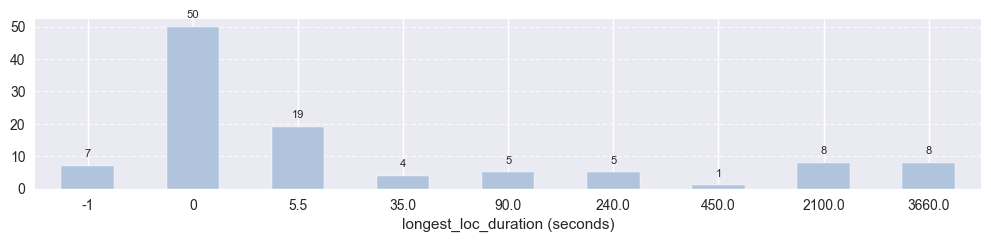

In [49]:
longest_loc_duration_clean_counts = (
    df["longest_loc_duration_clean"].value_counts().sort_index()
)

plt.figure(figsize=(10, 2.5))
bars = longest_loc_duration_clean_counts.plot(kind="bar", color="lightsteelblue")

# Iterate over the bars and use 'annotate' to display the count above each bar
for bar in bars.patches:
    plt.annotate(
        f"{int(bar.get_height())}",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.xlabel("longest_loc_duration (seconds)")
# plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [50]:
# ic(df.shape)
# df.head()

### Clean act_demented

Mapping "No Dementia" to 0 and "Dementia" to 1:

In [51]:
df['act_demented_clean'] = df['act_demented'].map({'No Dementia': 0, 'Dementia': 1})

In [52]:
df['act_demented_clean'].value_counts()

act_demented_clean
0    57
1    50
Name: count, dtype: int64

### Clean sex

In [53]:
df['sex'].value_counts()

sex
M    63
F    44
Name: count, dtype: int64

Mapping "F" to 0 and "M" to 1:

In [54]:
df['sex_clean'] = df['sex'].map({'F': 0, 'M': 1})

In [55]:
df['sex_clean'].value_counts()

sex_clean
1    63
0    44
Name: count, dtype: int64

### Clean apo_e4_allele

Mapping "N" to 0, "Y" to 1 and "unknown" to -1:

In [56]:
df['apo_e4_allele_clean'] = df['apo_e4_allele'].map({'N': 0, 'Y': 1, 'Unknown':-1})

In [57]:
df['apo_e4_allele_clean'].value_counts()

apo_e4_allele_clean
 0    80
 1    20
-1     7
Name: count, dtype: int64

### Clean ever_tbi_w_loc

Mapping "N" to 0, "Y" to 1:

In [58]:
df['ever_tbi_w_loc_clean'] = df['ever_tbi_w_loc'].map({'N': 0, 'Y': 1})

In [59]:
df['ever_tbi_w_loc_clean'].value_counts()

ever_tbi_w_loc_clean
1    57
0    50
Name: count, dtype: int64

### Quick value counts check to visually inspect the distributions and available values


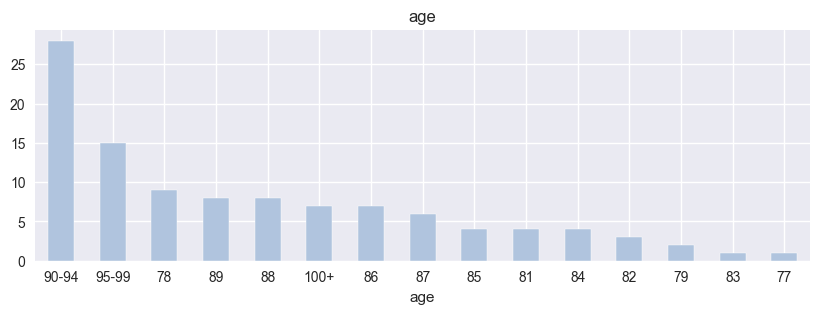

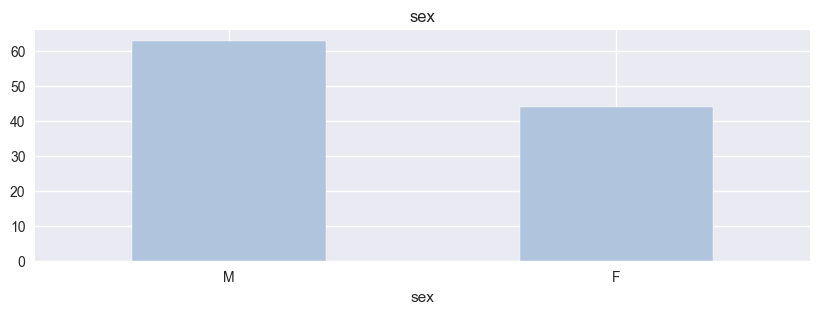

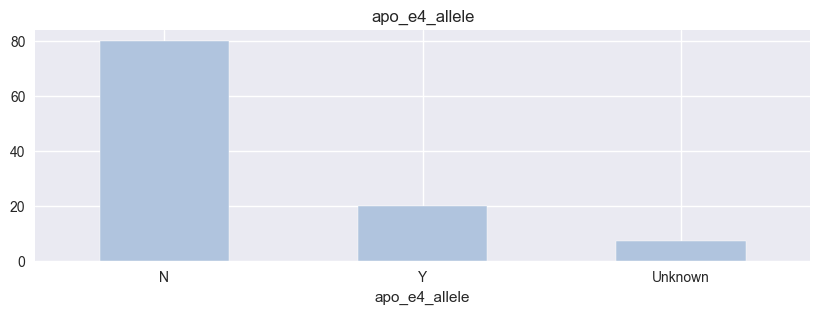

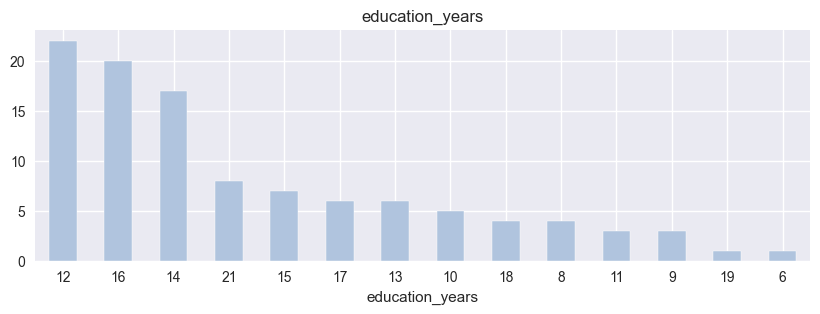

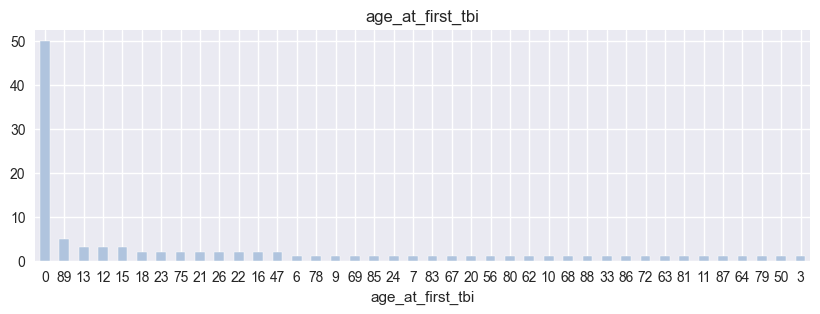

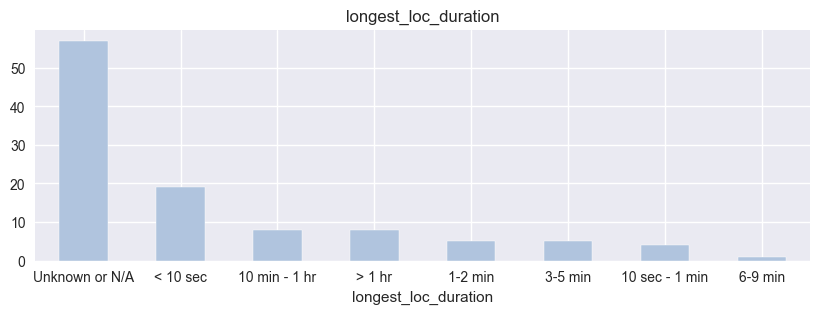

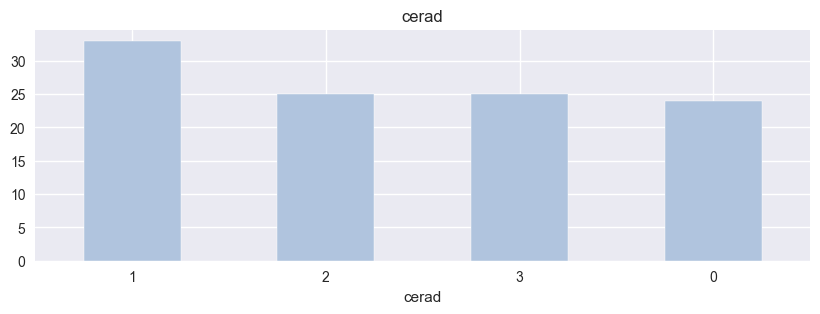

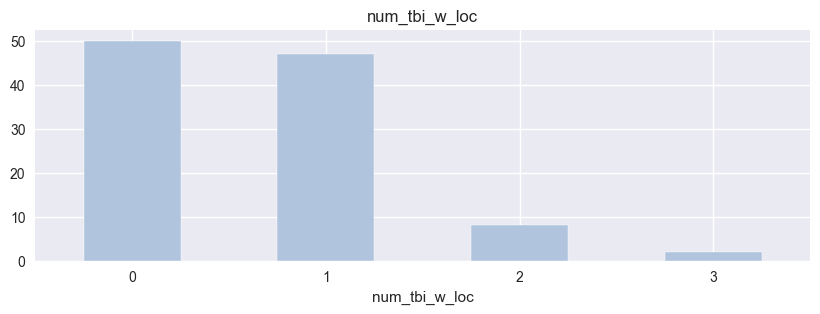

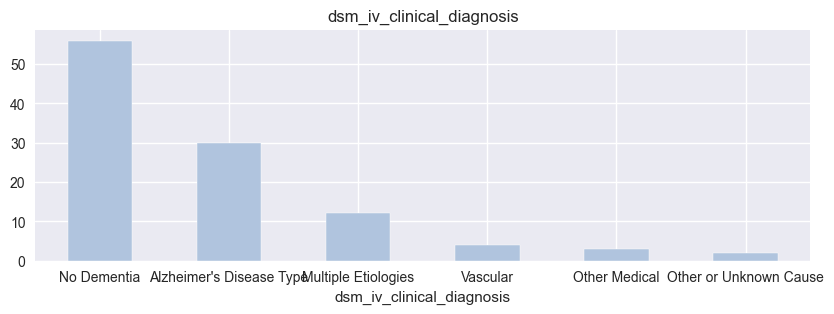

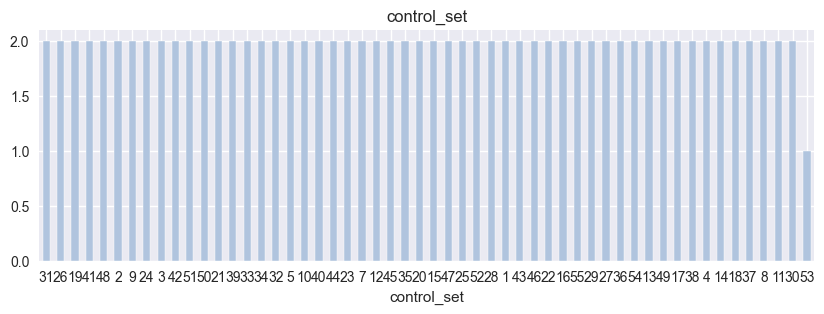

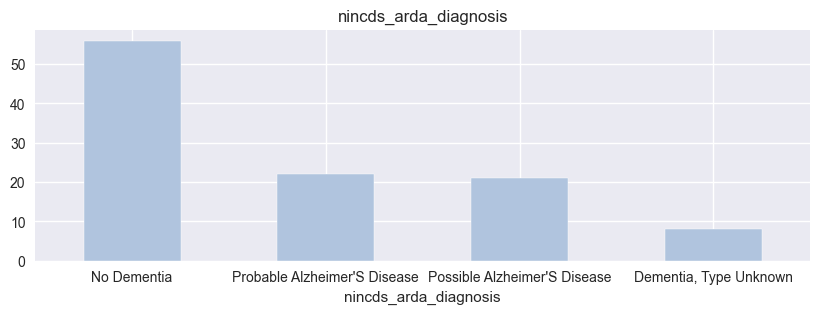

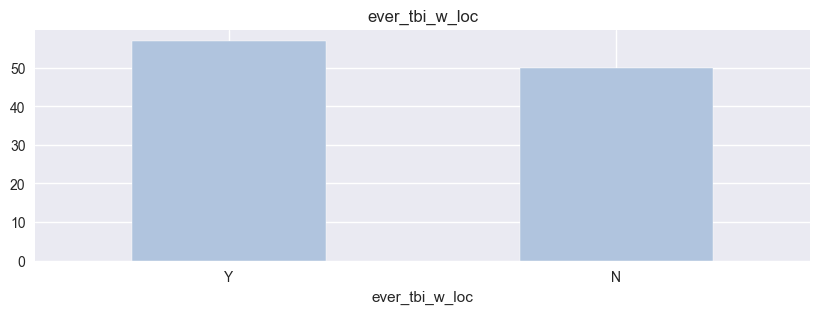

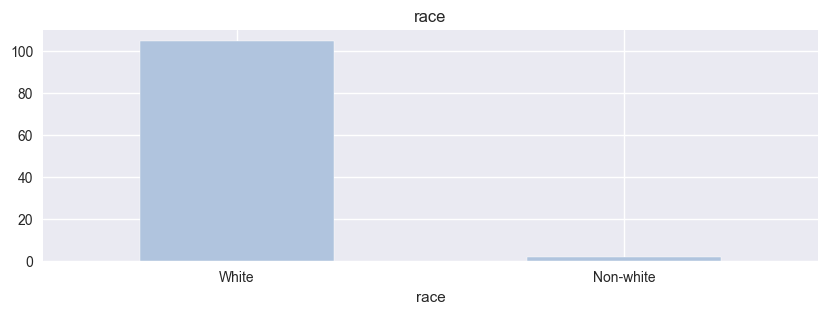

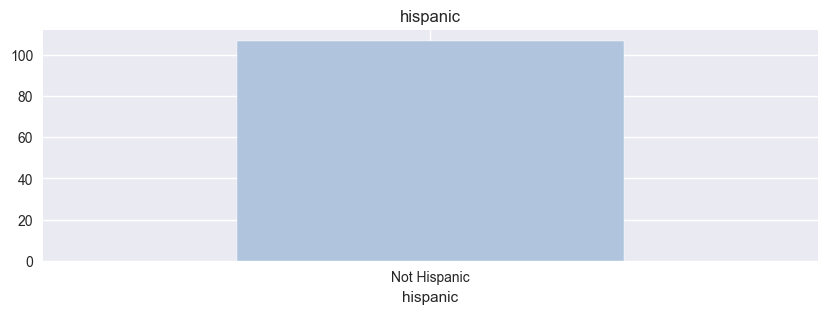

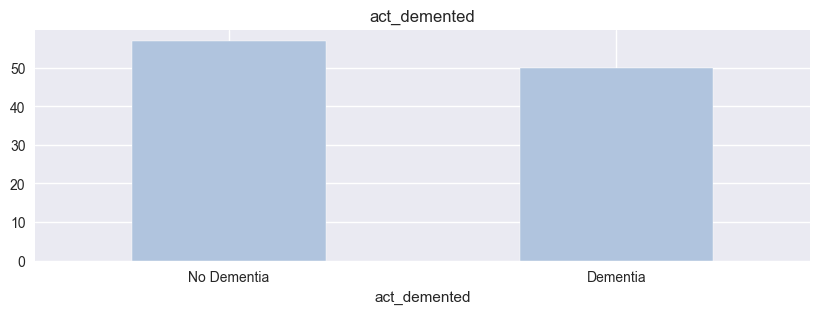

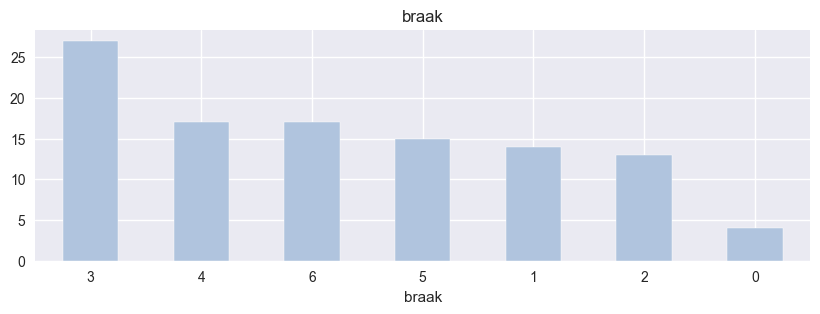

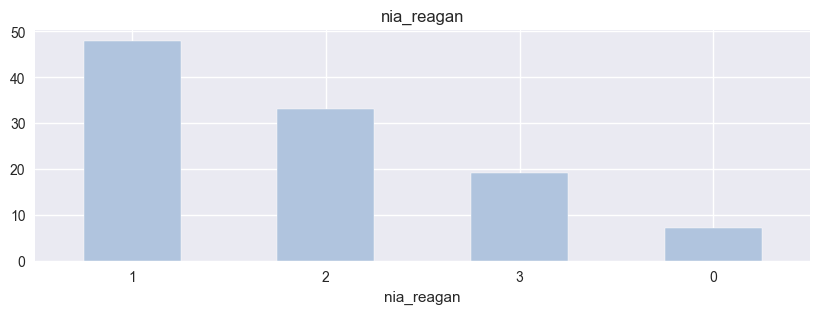

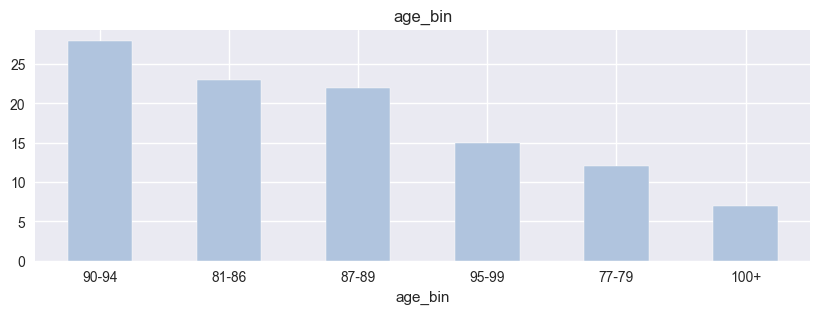

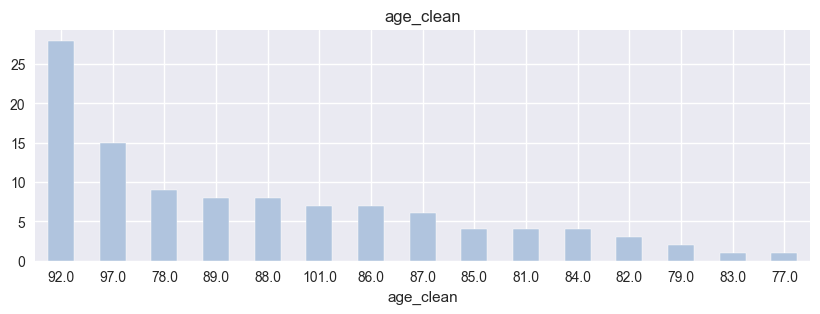

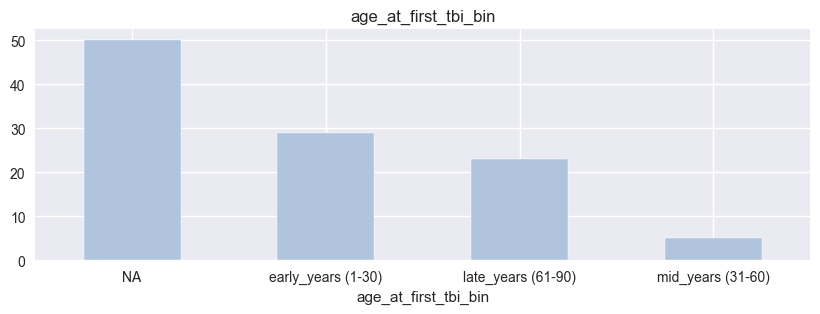

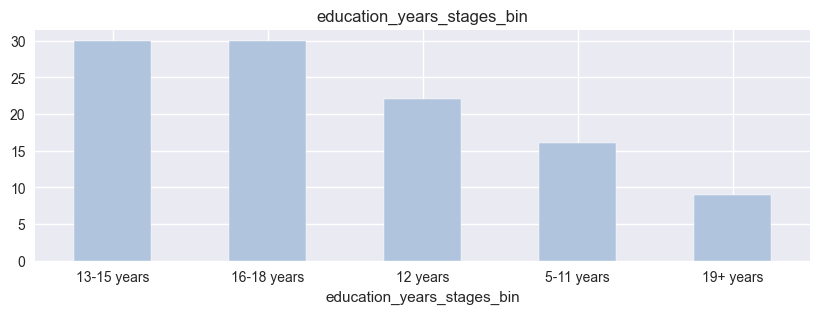

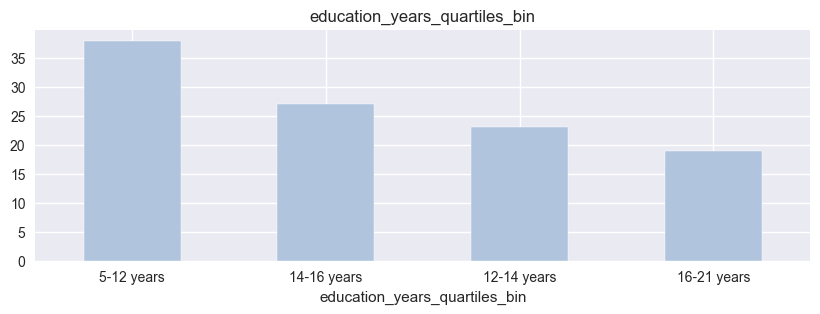

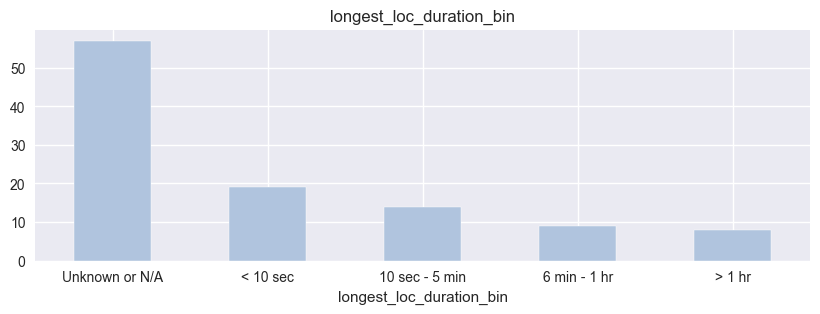

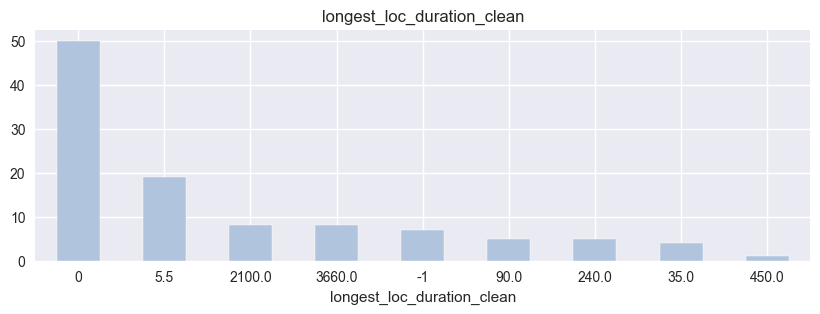

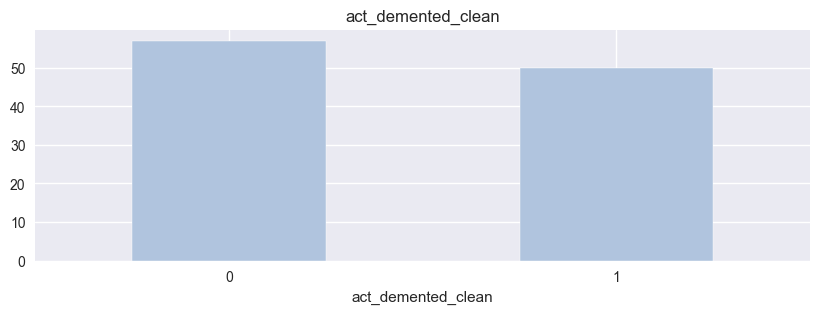

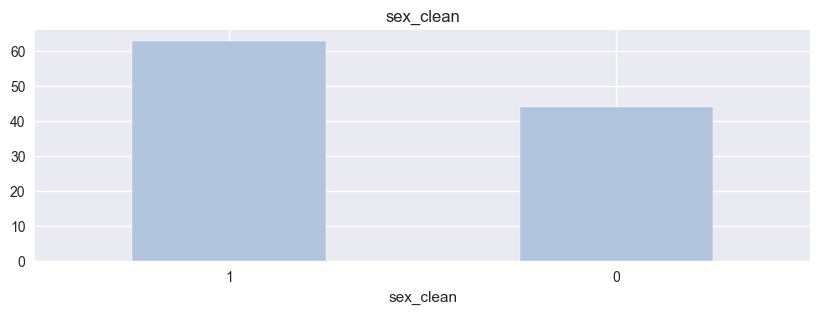

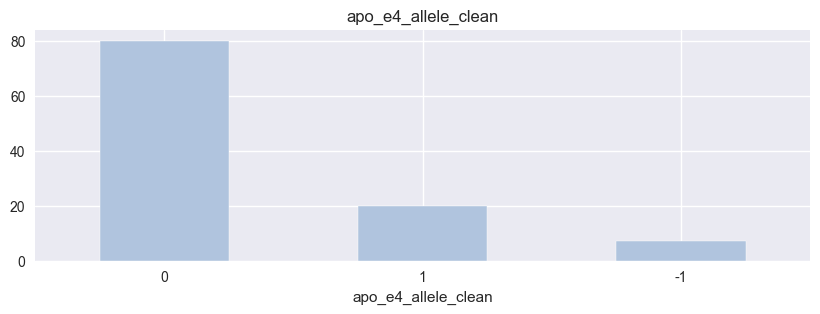

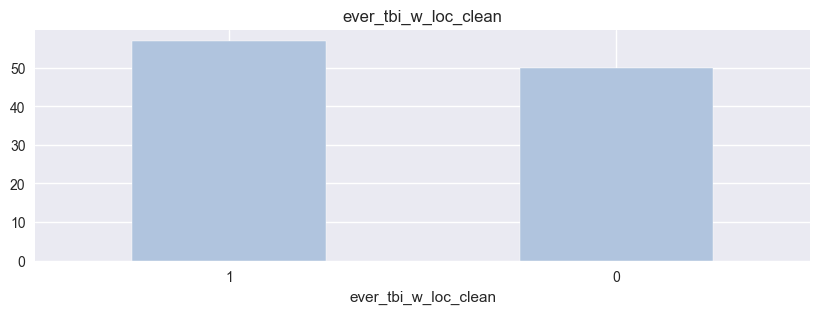

In [60]:
df_filtered = df.drop(
    columns=[
        "donor_id",
        "name",
    ]
)

for column in df_filtered.columns:
    values = df_filtered[column].value_counts()
    # print(values)
    values.plot(kind="bar", figsize=(10, 3), title=f"{column}", color="lightsteelblue")
    plt.xticks(rotation=0) 
    plt.show()
    print("=====" * 20)

### Looking at the control set

In [61]:
df[df["control_set"] == 1][["donor_id","age","sex","ever_tbi_w_loc", "act_demented"]]

,donor_id,age,sex,ever_tbi_w_loc,act_demented
5,309335457,95-99,F,N,No Dementia
66,309335456,95-99,F,Y,No Dementia


In [62]:
df[df["control_set"] == 2][["donor_id","age","sex","ever_tbi_w_loc", "act_demented"]]

,donor_id,age,sex,ever_tbi_w_loc,act_demented
39,309335438,90-94,M,Y,No Dementia
45,309335439,90-94,M,N,Dementia


In [63]:
df[df["control_set"] == 25][["donor_id","age","sex","ever_tbi_w_loc", "act_demented"]]

,donor_id,age,sex,ever_tbi_w_loc,act_demented
2,326765654,85,M,Y,Dementia
91,326765655,85,M,N,Dementia


In [64]:
df[df["control_set"] == 26][["donor_id","age","sex","ever_tbi_w_loc", "act_demented"]]

,donor_id,age,sex,ever_tbi_w_loc,act_demented
1,326765656,95-99,M,Y,No Dementia
9,326765657,95-99,M,N,No Dementia


In [65]:
df[df["control_set"] == 53][["name", "donor_id","age","sex","ever_tbi_w_loc", "act_demented"]]

,name,donor_id,age,sex,ever_tbi_w_loc,act_demented
95,H15.09.106,467056405,86,M,N,No Dementia


Control set 53 is the only one with an incomparable individual who had a TBI.

In [66]:
df.head()

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan,age_bin,age_clean,age_at_first_tbi_bin,education_years_stages_bin,education_years_quartiles_bin,longest_loc_duration_bin,longest_loc_duration_clean,act_demented_clean,sex_clean,apo_e4_allele_clean,ever_tbi_w_loc_clean
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1,87-89,87.000,NA,16-18 years,14-16 years,Unknown or N/A,0,0,1,0,0
1,326765656,H14.09.069,95-99,M,N,17,12,1-2 min,2,1,No Dementia,26,No Dementia,Y,White,Not Hispanic,No Dementia,5,2,95-99,97.000,early_years (1-30),16-18 years,16-21 years,10 sec - 5 min,90.000,0,1,0,1
2,326765654,H14.09.067,85,M,Y,10,72,< 10 sec,3,1,Vascular,25,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,2,81-86,85.000,late_years (61-90),5-11 years,5-12 years,< 10 sec,5.500,1,1,1,1
3,467056391,H15.09.103,90-94,F,N,11,87,< 10 sec,0,1,No Dementia,52,No Dementia,Y,White,Not Hispanic,No Dementia,4,0,90-94,92.000,late_years (61-90),5-11 years,5-12 years,< 10 sec,5.500,0,0,0,1
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2,100+,101.000,NA,16-18 years,14-16 years,Unknown or N/A,0,1,1,1,0


In [67]:
df['ever_tbi_w_loc'].value_counts()

ever_tbi_w_loc
Y    57
N    50
Name: count, dtype: int64

In [68]:
df['ever_tbi_w_loc_clean'].value_counts()

ever_tbi_w_loc_clean
1    57
0    50
Name: count, dtype: int64

## Quick Checks

### Quick Variance Check

In [69]:
# Convert categorical columns to numerical format using one-hot encoding
df_filtered = df.drop(
    columns=[
        "donor_id",
        "name",
        "age",
        "age_at_first_tbi",
        "education_years",
        "longest_loc_duration",
    ]
)
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Compute the variance for the entire dataset
var_matrix = df_encoded.var()

var_matrix.sort_values(ascending=False)

control_set                                          246.449
age_clean                                             41.008
braak                                                  2.982
cerad                                                  1.176
nia_reagan                                             0.733
num_tbi_w_loc                                          0.495
nincds_arda_diagnosis_No Dementia                      0.252
dsm_iv_clinical_diagnosis_No Dementia                  0.252
ever_tbi_w_loc_Y                                       0.251
longest_loc_duration_bin_Unknown or N/A                0.251
ever_tbi_w_loc_clean                                   0.251
act_demented_No Dementia                               0.251
longest_loc_duration_clean_0.0                         0.251
act_demented_clean                                     0.251
sex_M                                                  0.244
sex_clean                                              0.244
apo_e4_allele_clean     

### Quick Correlation Check

In [70]:
df_filtered = df.drop(
    columns=[
        "donor_id",
        "name",
        "age",
        "age_at_first_tbi",
        "education_years",
        "longest_loc_duration",
    ]
)
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Compute the correlation matrix for the entire dataset
correlation_matrix = df_encoded.corr()

# Display the correlation matrix
# correlation_matrix

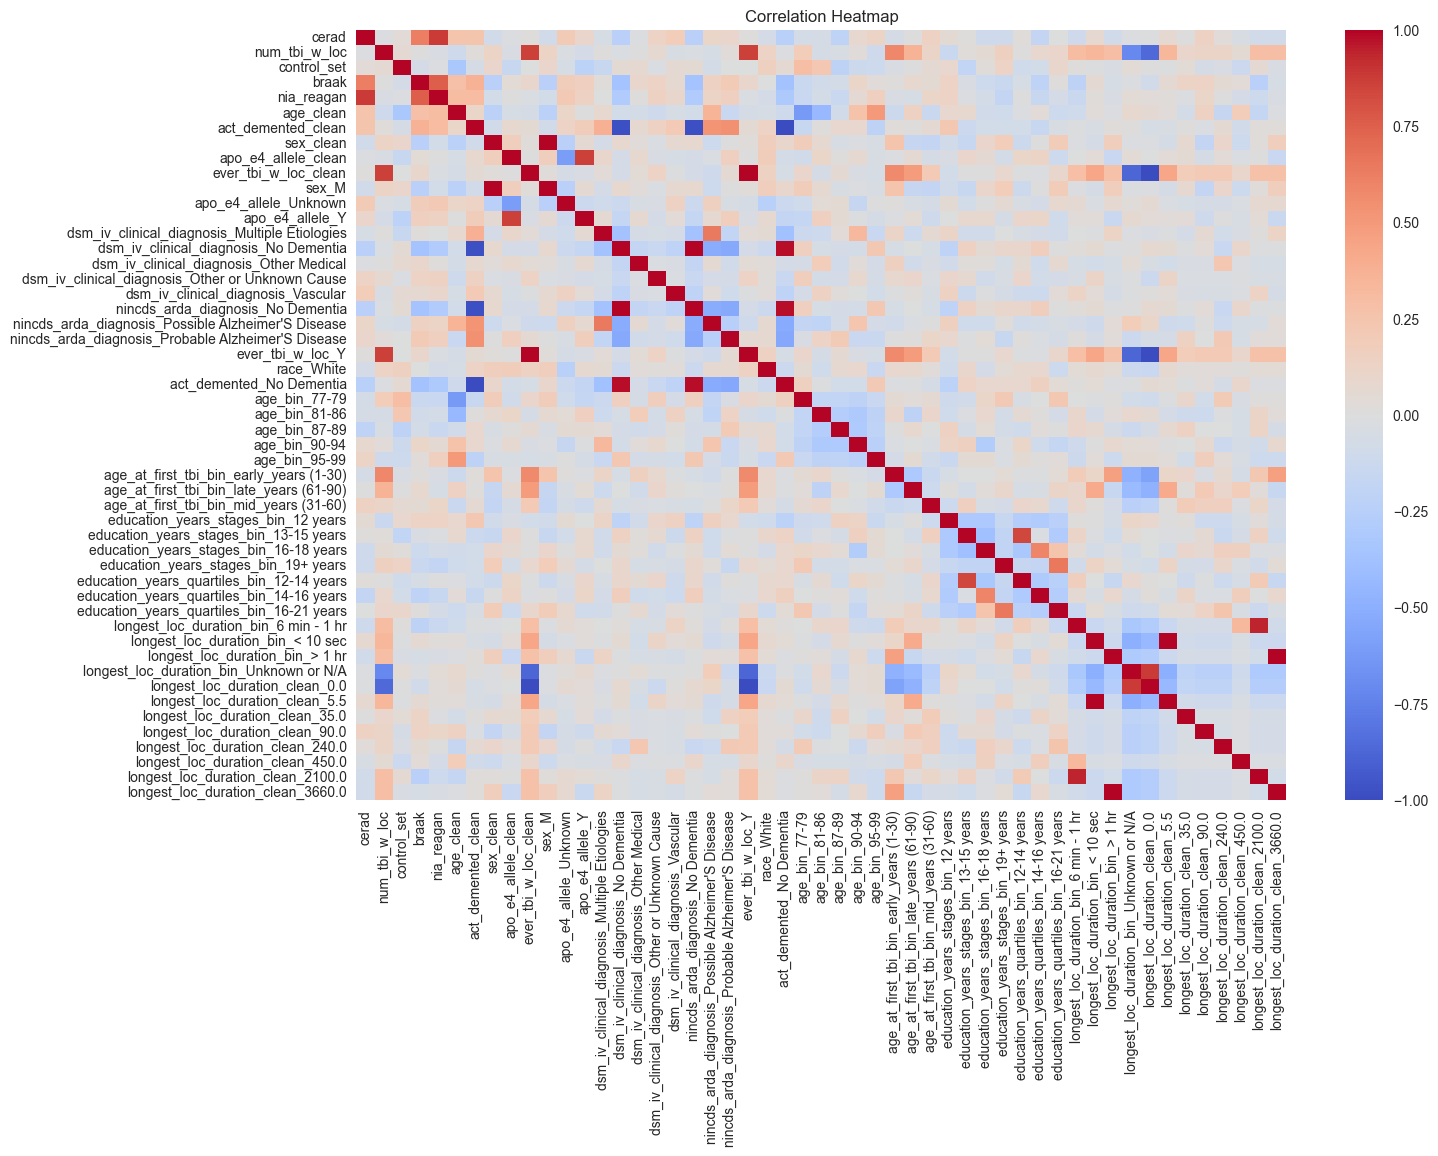

In [71]:
# Set the size for the heatmap
plt.figure(figsize=(15, 10))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Display the heatmap
plt.title("Correlation Heatmap")
plt.show()


#### Most significant correlations (top 10)

In [72]:
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

# Create a DataFrame from the correlation matrix stack
correlation_stack = correlation_matrix.stack()

# Reset the index to turn the index into columns
correlation_df = correlation_stack.reset_index()

# Name the columns
correlation_df.columns = ["Variable1", "Variable2", "Correlation"]

# Remove self-correlation
correlation_df = correlation_df[
    correlation_df["Variable1"] != correlation_df["Variable2"]
]

# Sort by absolute values of Correlation, descending
correlation_df["AbsCorrelation"] = correlation_df["Correlation"].abs()
sorted_correlation_df = correlation_df.sort_values("AbsCorrelation", ascending=False)

# Display the top N most significant correlations
top_n = 10  # Adjust this value to display more or fewer results
most_significant_correlations = sorted_correlation_df.head(top_n)

# Assuming we want to see the result here as a DataFrame
most_significant_correlations[["Variable1", "Variable2", "Correlation"]]

,Variable1,Variable2,Correlation
2214,longest_loc_duration_clean_0.0,ever_tbi_w_loc_Y,-1.000
2202,longest_loc_duration_clean_0.0,ever_tbi_w_loc_clean,-1.000
1114,ever_tbi_w_loc_Y,longest_loc_duration_clean_0.0,-1.000
502,ever_tbi_w_loc_clean,longest_loc_duration_clean_0.0,-1.000
1179,act_demented_No Dementia,act_demented_clean,-1.000
2591,longest_loc_duration_clean_3660.0,longest_loc_duration_bin_> 1 hr,1.000
517,sex_M,sex_clean,1.000
732,dsm_iv_clinical_diagnosis_No Dementia,nincds_arda_diagnosis_No Dementia,1.000
367,sex_clean,sex_M,1.000
480,ever_tbi_w_loc_clean,ever_tbi_w_loc_Y,1.000


Dropping highly correlated variables:
- 'dsm_iv_clinical_diagnosis_No Dementia',
- 'nincds_arda_diagnosis_No Dementia',
- 'act_demented_No Dementia',
- we may not want to drop both 'cerad' and 'nia_reagan' since they are not a perfect correlation.
    - 'cerad',

In [73]:
columns_to_drop = [
    "dsm_iv_clinical_diagnosis_No Dementia",
    "nincds_arda_diagnosis_No Dementia",
    "act_demented_No Dementia",
    # You may not want to drop both 'cerad' and 'nia_reagan' since they are not a perfect correlation.
    # It may depend on the context and importance of the features.
    "cerad",
    # 'nia_reagan',
]

df_encoded_dropped = df_encoded.drop(columns=columns_to_drop, errors="ignore")

In [74]:
# Compute the correlation matrix for the updated dataframe after dropping specified columns
correlation_matrix_dropped = df_encoded_dropped.corr()

# Create a DataFrame from the correlation matrix stack and reset index
correlation_df_dropped = correlation_matrix_dropped.stack().reset_index()
correlation_df_dropped.columns = [
    "Variable1",
    "Variable2",
    "Correlation",
]  # Name the columns

# Remove self-correlation and sort by absolute values of Correlation, descending
correlation_df_dropped = correlation_df_dropped[
    correlation_df_dropped["Variable1"] != correlation_df_dropped["Variable2"]
]
correlation_df_dropped["AbsCorrelation"] = correlation_df_dropped["Correlation"].abs()

# Filter out the upper triangle of the correlation matrix to remove duplicate pairs
unique_correlations = correlation_df_dropped[
    correlation_df_dropped["Variable1"] < correlation_df_dropped["Variable2"]
].sort_values("AbsCorrelation", ascending=False)

# Get the top 10 unique correlations
top_unique_correlations = unique_correlations.head(10)

# Display the top 10 unique correlations
top_unique_correlations = top_unique_correlations[
    ["Variable1", "Variable2", "Correlation"]
]
top_unique_correlations


,Variable1,Variable2,Correlation
415,ever_tbi_w_loc_clean,longest_loc_duration_clean_0.0,-1.000
885,ever_tbi_w_loc_Y,longest_loc_duration_clean_0.0,-1.000
854,ever_tbi_w_loc_Y,ever_tbi_w_loc_clean,1.000
429,sex_M,sex_clean,1.000
1732,longest_loc_duration_bin_< 10 sec,longest_loc_duration_clean_5.5,1.000
1785,longest_loc_duration_bin_> 1 hr,longest_loc_duration_clean_3660.0,1.000
1690,longest_loc_duration_bin_6 min - 1 hr,longest_loc_duration_clean_2100.0,0.938
414,ever_tbi_w_loc_clean,longest_loc_duration_bin_Unknown or N/A,-0.877
1825,longest_loc_duration_bin_Unknown or N/A,longest_loc_duration_clean_0.0,0.877
884,ever_tbi_w_loc_Y,longest_loc_duration_bin_Unknown or N/A,-0.877


## Exports

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   donor_id                       107 non-null    int64   
 1   name                           107 non-null    object  
 2   age                            107 non-null    object  
 3   sex                            107 non-null    object  
 4   apo_e4_allele                  107 non-null    object  
 5   education_years                107 non-null    int64   
 6   age_at_first_tbi               107 non-null    int64   
 7   longest_loc_duration           107 non-null    object  
 8   cerad                          107 non-null    int64   
 9   num_tbi_w_loc                  107 non-null    int64   
 10  dsm_iv_clinical_diagnosis      107 non-null    object  
 11  control_set                    107 non-null    int64   
 12  nincds_arda_diagnosis          107 n

In [76]:
# # Export
file = "donor_information_cleaned"
df.to_csv(ROOT_PATH + PATH_DATA_INT + f"{file}.csv")
df.to_parquet(ROOT_PATH + PATH_DATA_INT + f"{file}.parquet")

## Watermark

In [77]:
%load_ext watermark

In [78]:
%watermark

Last updated: 2023-12-11T16:34:56.138699+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.16.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [79]:
%watermark --iversions

seaborn   : 0.13.0
numpy     : 1.26.1
pandas    : 2.1.1
matplotlib: 3.8.0



-----


## Snapshot

In [80]:
today = date.today()
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}.html"
input_file = f"{notebook_name}.ipynb"
print(input_file)
!jupyter nbconvert --to html {input_file} --output {output_file}

01.01_clean_donorinfo.ipynb
[NbConvertApp] Converting notebook 01.01_clean_donorinfo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 42 image(s).
[NbConvertApp] Writing 1870886 bytes to ../reports/html/2023-12-11_01.01_clean_donorinfo.html


In [81]:
# Construct the output file path
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}_no_code.html"
print(output_file)
      
# Construct the input file path
input_file = f"{notebook_name}.ipynb"

# Convert the notebook to HTML without the code cells
os.system(f"jupyter nbconvert --to html {input_file} --output {output_file} --no-input")

../reports/html/2023-12-11_01.01_clean_donorinfo_no_code.html


[NbConvertApp] Converting notebook 01.01_clean_donorinfo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 42 image(s).
[NbConvertApp] Writing 1703728 bytes to ../reports/html/2023-12-11_01.01_clean_donorinfo_no_code.html


0